In [ ]:
import numpy as np
import seaborn as sns
import cv2
import os

import pybullet as p
import pybullet_data
import time

from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, Input

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
def convert_to_raw(input_dir, output_dir):
    
    for label in os.listdir(input_dir):
        label_path = os.path.join(input_dir, label)
        save_path = os.path.join(output_dir, label)
        os.makedirs(save_path, exist_ok=True)  

        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            
            img = cv2.imread(img_path)
            img = cv2.resize(img, (1280, 720)) 
            hand_region = img
            
            if hand_region is None or np.count_nonzero(hand_region) == 0:
                continue 
            
            output_file = os.path.join(save_path, f"{img_file.split('.')[0]}_raw.jpg")
            cv2.imwrite(output_file, hand_region)  #

# convert_to_raw('dataset/org', 'dataset/raw')

In [ ]:
# I) Data Augmentation 

def augment_images(input_dir, output_dir, augment_count=200):  
    data_gen = ImageDataGenerator(  
        rotation_range=20,    
        shear_range=0.2,   
        zoom_range=0.1,   
        brightness_range=[0.8, 1.4],
        # horizontal_flip=True,
        fill_mode='nearest'    
    )

    for label in os.listdir(input_dir):
        label_path = os.path.join(input_dir, label)
        save_path = os.path.join(output_dir, label)
        os.makedirs(save_path, exist_ok=True) 

        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)

            img = cv2.imread(img_path)   
            img = cv2.resize(img, (128,128))  

            img = img[np.newaxis, ...]  

            for i, augmented_img in enumerate(data_gen.flow(img, batch_size=1)):  
                cv2.imwrite(os.path.join(save_path, f"{img_file.split('.')[0]}_aug_{i}.jpg"),
                            augmented_img[0].astype(np.uint8))  
                if i > augment_count:
                    break

# augment_images('dataset/org', 'dataset/augmented')

In [ ]:
# II) Hand symbol CNN
def symbol_detection_model():
    model = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu', padding="same"),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding="same"),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding="same"),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding="same"),
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D(),

        Flatten(),
        Dense(128, activation='relu'),  
        Dense(8, activation='softmax')  # 8 gestures
    ])

    model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return model

train_data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.1)   

train_generator = train_data_gen.flow_from_directory(   
    'dataset/augmented', target_size=(128, 128), batch_size=32, class_mode='categorical', subset="training")
val_generator = train_data_gen.flow_from_directory(
    'dataset/augmented', target_size=(128, 128), batch_size=32, class_mode='categorical', subset="validation")

# Train Model

# model = symbol_detection_model()
# model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1)
# model.save('gesture_model.h5')

Found 43632 images belonging to 8 classes.
Found 4848 images belonging to 8 classes.


c:\Users\Shivaay Dhondiyal\Desktop\shivaay\coding\2_development\projects\hand gestures\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 541s 396ms/step - accuracy: 0.3184 - loss: 1.7114 - val_accuracy: 0.5062 - val_loss: 1.5581
Epoch 2/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 537s 377ms/step - accuracy: 0.9575 - loss: 0.1359 - val_accuracy: 0.5974 - val_loss: 2.0261
Epoch 3/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 449s 329ms/step - accuracy: 0.9938 - loss: 0.0236 - val_accuracy: 0.6285 - val_loss: 2.0307
Epoch 4/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 351s 258ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.6281 - val_loss: 1.9649
Epoch 5/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 474s 348ms/step - accuracy: 0.9999 - loss: 7.4489e-04 - val_accuracy: 0.5169 - val_loss: 2.5511
Epoch 6/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 425s 311ms/step - accuracy: 0.9939 - loss: 0.0205 - val_accuracy: 0.6498 - val_loss: 1.7976
Epoch 7/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 201s 147ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.6044 - val_loss: 1.6972
Epoch 8/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 195s 143ms/step 

152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step


<Axes: >

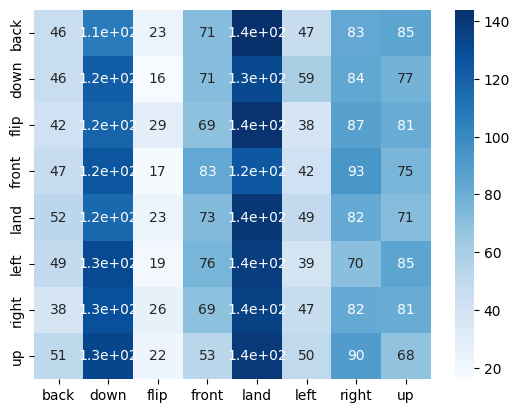

In [ ]:
# class is balanced
train_classes = train_generator.classes
val_classes = val_generator.classes

train_class_counts = np.bincount(train_classes)

# Get predictions for the validation set
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(val_classes, val_pred_labels)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())

In [ ]:
# III) functions
def setup_pybullet():
    if p.getConnectionInfo()['isConnected']:
        p.disconnect()

    p.connect(p.GUI)   # for visualization
    p.setAdditionalSearchPath(pybullet_data.getDataPath()) 
    p.resetSimulation()     
    p.setGravity(0, 0, -9.8)

    drone = p.loadURDF("r2d2.urdf", [0, 0, 1])
    return drone


def move_drone(drone, command):
    f = 10     
    if command == "up":    
        p.applyExternalForce(drone, -1, [0, 0, f], [0, 0, 0], p.WORLD_FRAME)
    elif command == "down":
        p.applyExternalForce(drone, -1, [0, 0, -f], [0, 0, 0], p.WORLD_FRAME)
    elif command == "left":
        p.applyExternalForce(drone, -1, [-f, 0, 0], [0, 0, 0], p.WORLD_FRAME)
    elif command == "right":
        p.applyExternalForce(drone, -1, [f, 0, 0], [0, 0, 0], p.WORLD_FRAME)
    # elif command == "forward":
    #     p.applyExternalForce(drone, -1, [0, f, 0], [0, 0, 0], p.WORLD_FRAME)
    # elif command == "backward":
    #     p.applyExternalForce(drone, -1, [0, -f, 0], [0, 0, 0], p.WORLD_FRAME)
    # elif command == "flip":
    #     p.applyExternalForce(drone, -1, [0, f, 0], [0, 0, 0], p.WORLD_FRAME)  
    # elif command == "land":
    #     p.applyExternalForce(drone, -1, [0, -f, 0], [0, 0, 0], p.WORLD_FRAME)


def predict_gesture(frame, model):
    img = cv2.resize(frame, (128, 128))  
    img = img / 255  
    processed_frame = np.expand_dims(img, axis=0)  

    pred = model.predict(processed_frame)  
    gesture_labels = ["up", "down", "left", "right", "forward", "backward", 'flip', 'land']  
    pred_label = gesture_labels[np.argmax(pred)]       

    return pred_label

In [ ]:
# IV) Main document 

model = load_model('gesture_model.h5')
drone = setup_pybullet()

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    

while True:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Camera Feed", frame)  
    gesture = predict_gesture(frame, model) 
    print(f"Predicted Gesture: {gesture}")
    move_drone(drone, gesture)

    if cv2.waitKey(1) & 0xFF == ord('q'):  
        break

    p.stepSimulation()   
    time.sleep(0.5)    

cap.release()   
cv2.destroyAllWindows()  
p.disconnect()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted Gesture: down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted Gesture: down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Gesture: down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Gesture: down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Gesture: down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Gesture: down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Gesture: down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Gesture: down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Gesture: flip
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Gesture: flip
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Gesture: flip
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Gesture: flip
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Gesture: down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Gesture: down
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Gesture: flip
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Gesture: flip
1/1 ━━━

error: Not connected to physics server.